In [2]:
import os
import anndata
import anndata as ad
from pathlib import Path
import os
import pandas as pd
import numpy as np
import torch
from bokeh.transform import transform
from tqdm import tqdm
from scipy.stats import norm
from typing import Tuple

# Loading data

In [3]:
x_hat_s = anndata.read_h5ad(Path(os.getcwd()).parents[0] / "data" / "processed" / "mouse1_slice153_x_hat_s.h5ad")

# Method
## Calculate Ligand and Receptor score

For each ligand (receptor) _g_ in cluster _k_, we compute a score $S(g,k)\in [0,1]$ aimed at measuring how much the observed ligand (receptor) average expression level $\bar{X}_{g}^{k}$ is high compared to the average expression levels observable by ranche for random genes in the same cluster _k_. The distribution of average gene expression level observable by chance was obtained, using a permutation approach, as follows:
i) randomly permuting row/genes in matrix $X^k$ independently for each column/cell;
ii) computing the average genes expression levels in such shuffled version of $X^{k}$;
iii) iterating steps (i) and (ii) multiple times.

In [4]:
import liana as li
lr_df = li.resource.select_resource("mouseconsensus")
lr_df["ligand"]=lr_df["ligand"].str.lower()
lr_df["receptor"]=lr_df["receptor"].str.lower()

## Calculate Ligand and Receptor Pair Score

## Define utility functions to evaluate the intercellular scores

In [5]:
def compute_gene_cluster_stats(adata: ad.AnnData, cluster_key="@label", verbose: int = 0) -> ad.AnnData:
    clusters = adata.obs[cluster_key].cat.categories
    cluster_stats = {}
    for cluster in clusters:
        if verbose == 1 | verbose == 2:
            print(f"\nProcessing cluster: {cluster}")
        cell_mask = adata.obs[cluster_key] == cluster
        cluster_data = adata[cell_mask].X
        cluster_stats[cluster] = {
            "mu": np.mean(cluster_data, axis=None),
            "sd": np.std(cluster_data, axis=None),
            "counts": cluster_data.shape[0]
        }
        gene_means = np.mean(cluster_data, axis=0)
        gene_scores = norm.cdf(gene_means, loc=cluster_stats[cluster]["mu"],
                               scale=cluster_stats[cluster]["sd"] / np.sqrt(cluster_stats[cluster]["counts"]))
        gene_scores[gene_means == 0] = 0
        score_key = f'score_{cluster}'
        adata.var[score_key] = gene_scores

    return adata

In [6]:
def prepare_lr_data(adata: ad.AnnData, lr_pairs_df: pd.DataFrame, verbose: int = 0) -> Tuple[ad.AnnData, pd.DataFrame]:
    # First, identify complex molecules
    lr_pairs_df["is_ligand_complex"] = lr_pairs_df["ligand"].str.contains("_")
    lr_pairs_df["ligand_complex_components"] = lr_pairs_df["ligand"].str.split("_")
    lr_pairs_df["is_receptor_complex"] = lr_pairs_df["receptor"].str.contains("_")
    lr_pairs_df["receptor_complex_components"] = lr_pairs_df["receptor"].str.split("_")
    lr_pairs_df["is_interaction_complex"] = lr_pairs_df["is_ligand_complex"] | lr_pairs_df["is_receptor_complex"]

    # Get all unique components
    ligands = set(lr_pairs_df["ligand_complex_components"].explode())
    receptors = set(lr_pairs_df["receptor_complex_components"].explode())

    # Find which components exist in adata
    valid_ligands = ligands.intersection(adata.var_names)
    valid_receptors = receptors.intersection(adata.var_names)

    # Filter lr_pairs_df to keep only pairs where all components exist in adata
    valid_pairs_mask = lr_pairs_df.apply(
        lambda row: all(comp in valid_ligands for comp in row["ligand_complex_components"]) and
                   all(comp in valid_receptors for comp in row["receptor_complex_components"]),
        axis=1
    )

    lr_pairs_df = lr_pairs_df[valid_pairs_mask].copy()

    # Update adata to keep only genes that are part of valid pairs
    all_valid_genes = valid_ligands.union(valid_receptors)
    adata = adata[:, adata.var_names.isin(all_valid_genes)].copy()

    if verbose:
        print(f"Filtered from {len(ligands.union(receptors))} to {len(all_valid_genes)} total genes")
        print(f"Filtered from {len(valid_pairs_mask)} to {valid_pairs_mask.sum()} valid L-R pairs")

    return adata, lr_pairs_df

In [7]:
def compute_lr_scores(adata: ad.AnnData, lr_pairs_df: pd.DataFrame, cluster_key="@label", verbose: int = 0) -> pd.DataFrame:
    # Create base L-R pairs first (more efficient)
    lr_pairs = lr_pairs_df["ligand"] + "&" + lr_pairs_df["receptor"]
    clusters = adata.obs[cluster_key].astype("category").cat.categories

    # Create all combinations
    interactions = [
        f"{lr}&{source}&{target}"
        for lr in lr_pairs
        for source in clusters
        for target in clusters
    ]

    # Create DataFrame with ordered interactions
    lr_scores = pd.DataFrame(
        [x.split('&') for x in interactions],
        columns=['ligand', 'receptor', 'source', 'target'],
        index=interactions
    )
    lr_scores['is_ligand_complex'] = lr_scores['ligand'].str.contains("_")
    lr_scores['is_receptor_complex'] = lr_scores['receptor'].str.contains("_")
    lr_scores["ligand_score"] = np.zeros(len(lr_scores))
    lr_scores["receptor_score"] = np.zeros(len(lr_scores))

    def compute_complex_score(adata, complex_molecule: str, cluster_score_key: str) -> float:
        components = complex_molecule.split("_")
        component_scores = adata.var.loc[components, cluster_score_key].values
        complex_score = np.exp(np.mean(np.log(component_scores)))
        return complex_score

    for i, row in tqdm(enumerate(lr_scores.itertuples()), total=len(lr_scores), disable=verbose != 2, desc="Calculating L-R scores"):
        # print(f"Processing interaction {row}")
        if row.is_ligand_complex:
            lr_scores.loc[row[0],"ligand_score"] = compute_complex_score(adata, row.ligand, f"score_{row.source}")
        else:
            lr_scores.loc[row[0],"ligand_score"] = adata.var.loc[row.ligand,f"score_{row.source}"]
        if row.is_receptor_complex:
            lr_scores.loc[row[0],"receptor_score"] = compute_complex_score(adata, row.receptor, f"score_{row.target}")
        else:
            lr_scores.loc[row[0],"receptor_score"] = adata.var.loc[row.receptor, f"score_{row.target}"]
        # print(f"Processed interaction to {lr_scores.loc[row[0]]}")
    lr_scores["score"] = np.minimum(lr_scores["ligand_score"], lr_scores["receptor_score"])

    return lr_scores

In [8]:
data = x_hat_s.copy()
data, complex_info = prepare_lr_data(data, lr_df)
data = compute_gene_cluster_stats(data, cluster_key='subclass', verbose=2)

## Calculate Intercellular scores

In [9]:
try:
    lr_scores = pd.read_csv(Path(os.getcwd()).parents[0] / "data" / "processed" / "mouse1_slice153_lr_inter_scores.csv",
                            index_col=0)
except FileNotFoundError:
    lr_scores = compute_lr_scores(adata, complex_info, cluster_key='subclass', verbose=2)
    lr_scores.to_csv(
    Path(os.getcwd()).parents[0] / "data" / "processed" / "mouse1_slice153_lr_inter_scores.csv")

In [10]:
# select top 3 lr pairs between clusters ASTRO and L2/3 IT
source = "Astro"
target = "L2/3 IT"
df = lr_scores.query(f"source == '{source}' & target == '{target}'")
df.sort_values(by="score", ascending=False).head(10)

,ligand,receptor,source,target,is_ligand_complex,is_receptor_complex,ligand_score,receptor_score,score
gnai2&cnr1&Astro&L2/3 IT,gnai2,cnr1,Astro,L2/3 IT,False,False,1.0,1.0,1.0
gnai2&oprm1&Astro&L2/3 IT,gnai2,oprm1,Astro,L2/3 IT,False,False,1.0,1.0,1.0
arf1&insr&Astro&L2/3 IT,arf1,insr,Astro,L2/3 IT,False,False,1.0,1.0,1.0
fstl1&dip2a&Astro&L2/3 IT,fstl1,dip2a,Astro,L2/3 IT,False,False,1.0,1.0,1.0
rtn4&rtn4r&Astro&L2/3 IT,rtn4,rtn4r,Astro,L2/3 IT,False,False,1.0,1.0,1.0
gnai2&adcy1&Astro&L2/3 IT,gnai2,adcy1,Astro,L2/3 IT,False,False,1.0,1.0,1.0
rtn4&lingo1&Astro&L2/3 IT,rtn4,lingo1,Astro,L2/3 IT,False,False,1.0,1.0,1.0
apoe&sorl1&Astro&L2/3 IT,apoe,sorl1,Astro,L2/3 IT,False,False,1.0,1.0,1.0
rtn4&tnfrsf19&Astro&L2/3 IT,rtn4,tnfrsf19,Astro,L2/3 IT,False,False,1.0,1.0,1.0
bsg&slc16a7&Astro&L2/3 IT,bsg,slc16a7,Astro,L2/3 IT,False,False,1.0,1.0,1.0


/home/bio/PhD/projects/mlnetst/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.


/home/bio/PhD/projects/mlnetst/.venv/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.


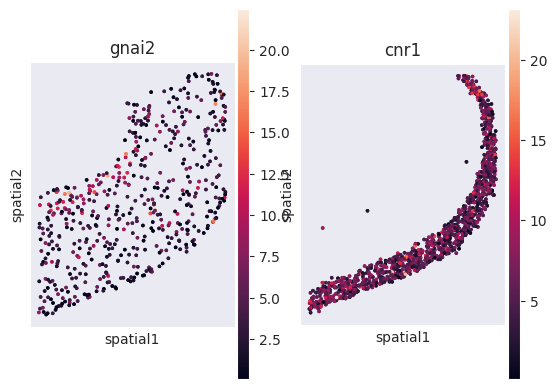

In [11]:
import matplotlib.pyplot as plt
import squidpy as sq
fig, axs = plt.subplots(ncols = 2)
axs = axs.flatten()
data.obsm["spatial"] = np.array([(x,y) for x,y in zip(data.obs["centroid_x"], data.obs["centroid_y"])])
features = ["gnai2","cnr1"]
groups = [source, target]
for i,ax in enumerate(axs):
    sq.pl.spatial_scatter(
        data[(data.obs["subclass"] == groups[i]),:],
        color = features[i],
        shape=None,
        size=10,
        ax=ax,
    )

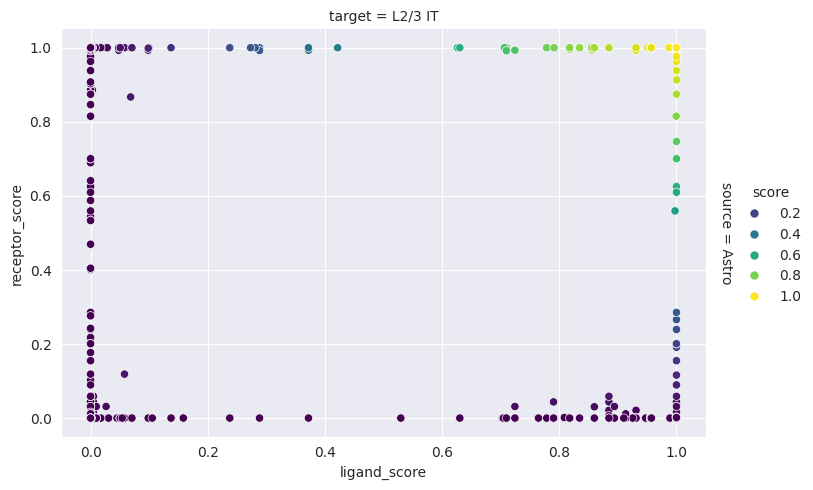

In [12]:
import seaborn as sns
subset_lr_scores = lr_scores.query(f"source == '{source}' & target == '{target}'")
sns.relplot(subset_lr_scores, kind="scatter", x="ligand_score", y="receptor_score", row="source", col="target", hue="score", palette="viridis", aspect=1.5,
            facet_kws=dict(margin_titles=True),)

# Let's implement somewhat an idea of score with a distance metric


In [13]:
from torch.utils.data import DataLoader, Dataset
import torch

In [14]:
subdata = data[(data.obs["subclass"] == source) | (data.obs["subclass"] == target),:]
top_k_interactions = 200
print(lr_df.shape)
potential_interactions = lr_scores.query(f"source == '{source}' & target == '{target}'").loc[:,["ligand","receptor","score"]].sort_values(by="score",ascending=False).head(top_k_interactions)
print(potential_interactions)

(3989, 7)
                            ligand receptor     score
gnai2&cnr1&Astro&L2/3 IT     gnai2     cnr1  1.000000
gnai2&oprm1&Astro&L2/3 IT    gnai2    oprm1  1.000000
arf1&insr&Astro&L2/3 IT       arf1     insr  1.000000
fstl1&dip2a&Astro&L2/3 IT    fstl1    dip2a  1.000000
rtn4&rtn4r&Astro&L2/3 IT      rtn4    rtn4r  1.000000
...                            ...      ...       ...
vegfa&nrp2&Astro&L2/3 IT     vegfa     nrp2  0.815001
nrg2&nrp2&Astro&L2/3 IT       nrg2     nrp2  0.815001
ndp&lgr4&Astro&L2/3 IT         ndp     lgr4  0.790930
adam17&erbb4&Astro&L2/3 IT  adam17    erbb4  0.778493
adam17&itgb1&Astro&L2/3 IT  adam17    itgb1  0.778493

[200 rows x 3 columns]


In [15]:
n_spatial_locations = subdata.shape[0]
n_potential_interactions = potential_interactions.shape[0]
x_lr = torch.zeros((n_spatial_locations, n_spatial_locations, n_potential_interactions), dtype=torch.float32)

In [16]:
# Indexing torch tensors
t = torch.ones((3,4,5), dtype=torch.float)
print(f"Shape: {t.size()}")
print(f"First row 2D Matrix: {t[0,:,:]}")
## assigning zeros to whole first column on second dimension slice
t[:,0,:] = 0
# Joining tensors
t1 = torch.cat([t,t], dim=1)
# Arithmetic operations
y1 = t[:,:,0] @ t[:,:,0].T
y2 = t[:,:,0].matmul(t[:,:,0].T)
y3 = torch.rand_like(y1)
torch.matmul(t[:,:,0], t[:,:,0].T, out=y3)

Shape: torch.Size([3, 4, 5])
First row 2D Matrix: tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])


tensor([[3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.]])

In [17]:
potential_interactions

,ligand,receptor,score
gnai2&cnr1&Astro&L2/3 IT,gnai2,cnr1,1.000000
gnai2&oprm1&Astro&L2/3 IT,gnai2,oprm1,1.000000
arf1&insr&Astro&L2/3 IT,arf1,insr,1.000000
fstl1&dip2a&Astro&L2/3 IT,fstl1,dip2a,1.000000
rtn4&rtn4r&Astro&L2/3 IT,rtn4,rtn4r,1.000000
...,...,...,...
vegfa&nrp2&Astro&L2/3 IT,vegfa,nrp2,0.815001
nrg2&nrp2&Astro&L2/3 IT,nrg2,nrp2,0.815001
ndp&lgr4&Astro&L2/3 IT,ndp,lgr4,0.790930
adam17&erbb4&Astro&L2/3 IT,adam17,erbb4,0.778493


In [18]:
single_lr = torch.zeros((n_spatial_locations, n_spatial_locations), dtype=torch.float32)
which_interaction_index = 0
ligand_mask = torch.from_numpy(subdata[:, potential_interactions.iloc[which_interaction_index]["ligand"]].X)
receptor_mask = torch.from_numpy(subdata[:, potential_interactions.iloc[which_interaction_index]["receptor"]].X)
spatial_position_matrix = torch.tensor(subdata.obsm["spatial"], dtype=torch.float32)
print(spatial_position_matrix.shape)
dist_matrix = torch.cdist(spatial_position_matrix, spatial_position_matrix, p=2)
print(dist_matrix.shape)
# How can i display these distances in a 2d plot


torch.Size([1715, 2])
torch.Size([1715, 1715])


In [19]:
single_lr = torch.div(ligand_mask @ receptor_mask.T, dist_matrix + 1e-5)
# set the diagonal to zero
single_lr = single_lr.fill_diagonal_(0)


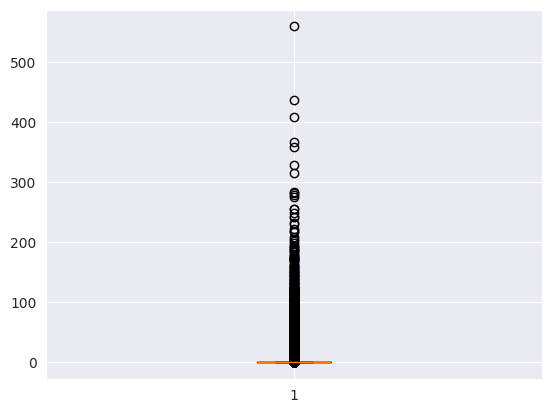

2.2083082


KeyboardInterrupt: 

In [31]:
plt.boxplot(single_lr.numpy().flatten())
plt.show()
print(np.quantile(single_lr.numpy().flatten(), 0.95))
sns.scatterplot(single_lr, col=source, row=target)

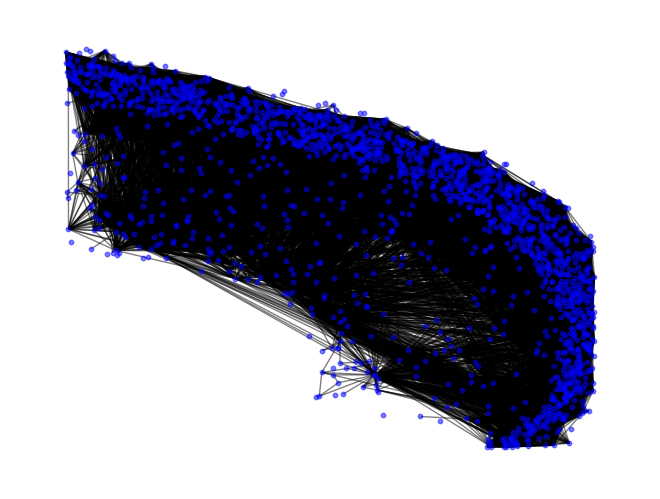

In [21]:
import networkx as nx
mask = single_lr > np.quantile(single_lr.numpy().flatten(), 0.95)
masked_single_lr = single_lr * mask
g = nx.from_numpy_array(masked_single_lr.numpy())
pos = [(x,y) for x,y in zip(spatial_position_matrix[:,0].numpy(), spatial_position_matrix[:,1].numpy())]
nx.draw(g, pos, node_size=10, node_color="blue", alpha=0.5)

# Try to scale up

In [38]:
try_top_interactions = 100
spatial_position_matrix = torch.tensor(subdata.obsm["spatial"], dtype=torch.float32)
dist_matrix = torch.cdist(spatial_position_matrix, spatial_position_matrix, p=2)

# first iteration
ligand_mask = torch.from_numpy(subdata[:, potential_interactions.iloc[0]["ligand"]].X.astype(np.float32))
receptor_mask = torch.from_numpy(subdata[:, potential_interactions.iloc[0]["receptor"]].X.astype(np.float32))
single_lr = torch.div(ligand_mask @ receptor_mask.T, dist_matrix + 1e-5)
single_lr = single_lr.fill_diagonal_(0)
mask = single_lr > np.quantile(single_lr.numpy().flatten(), 0.95)
masked_single_lr = single_lr * mask
cells_inter_scores = masked_single_lr.to_sparse()
for i,k in tqdm(enumerate(potential_interactions.index)):
    if i == 0:
        continue
    if i >= try_top_interactions:
        break
    ligand_mask = torch.from_numpy(subdata[:, potential_interactions.iloc[i]["ligand"]].X.astype(np.float32))
    receptor_mask = torch.from_numpy(subdata[:, potential_interactions.iloc[i]["receptor"]].X.astype(np.float32))
    single_lr = torch.div(ligand_mask @ receptor_mask.T, dist_matrix + 1e-5)
    single_lr = single_lr.fill_diagonal_(0)
    mask = single_lr > np.quantile(single_lr.numpy().flatten(), 0.95)
    masked_single_lr = single_lr * mask
    cells_inter_scores = torch.dstack([cells_inter_scores, masked_single_lr.to_sparse()])
print(type(cells_inter_scores), cells_inter_scores.shape)
print(cells_inter_scores)


91it [00:08, 11.09it/s]


KeyError: 'itgav_itgb1'

In [23]:
print(cells_inter_scores.sparse_dim(), cells_inter_scores.dense_dim())

3 0


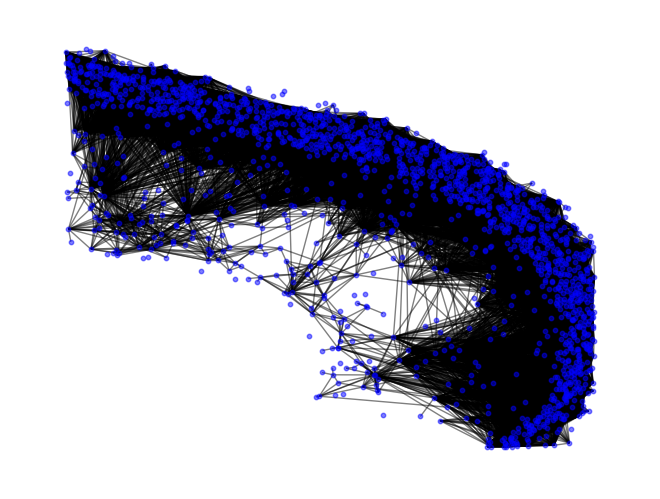

In [37]:
which_interaction_index = 8
# learn how to slice a sparse tensor, which is not supported, but we could index it (?)
adj = cells_inter_scores.to_dense()[:,:,which_interaction_index].numpy()
g = nx.from_numpy_array(adj)
pos = [(x,y) for x,y in zip(spatial_position_matrix[:,0].numpy(), spatial_position_matrix[:,1].numpy())]
nx.draw(g, pos, node_size=10, node_color="blue", alpha=0.5)


In [25]:
from lightning import LightningDataModule
# The dataset is expected to be something like x_lr
# we will consider for each interaction a different image of n_locations x n_locations
class CustomInterScoreDataset(LightningDataModule):
    def __init__(self, annotations_file):
        self.interaction_labels = pd.read_csv(annotations_file)

    def __len__(self):
        return len(self.interaction_labels)

    def __getitem__(self, idx):
        pass





In [48]:
import nichecompass as nc
lrt_interactions = nc.utils.extract_gp_dict_from_nichenet_lrt_interactions(
    species="mouse",
    gene_orthologs_mapping_file_path=Path(os.getcwd()).parents[0] / "data" / "raw" / "human_mouse_gene_orthologs.csv",
    plot_gp_gene_count_distributions=False,
)
lrt_df = pd.DataFrame.from_dict(lrt_interactions, orient='index')

/home/bio/PhD/projects/mlnetst/.venv/lib/python3.12/site-packages/nichecompass/utils/gene_programs.py:496: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


In [49]:
# Import nichenet from gr.csv and lr_sig.csv
gr_df = pd.read_csv(Path(os.getcwd()).parents[0] / "data" / "raw" / "gr.csv", index_col=0)

In [50]:
gr_df

,to,weight
from,,
0610010K14Rik,0610010K14Rik,0.120670
0610010K14Rik,2510039O18Rik,0.120596
0610010K14Rik,2610021A01Rik,0.025641
0610010K14Rik,9130401M01Rik,0.026292
0610010K14Rik,Alg1,0.127445
...,...,...
Zzz3,Zp3,0.163414
Zzz3,Zranb2,0.123297
Zzz3,Zscan29,0.025354


In [51]:
lr_sig_df = pd.read_csv(Path(os.getcwd()).parents[0] / "data" / "raw" / "lr_sig.csv", index_col=0)

In [52]:
lr_sig_df

,to,weight
from,,
0610010F05Rik,App,0.109896
0610010F05Rik,Cat,0.067324
0610010F05Rik,H1f2,0.066010
0610010F05Rik,Lrrc49,0.082884
0610010F05Rik,Nicn1,0.086396
...,...,...
Zzz3,Zfp212,0.151507
Zzz3,Zfp513,0.152448
Zzz3,Zfp65,0.096104


In [53]:
lrt_df

,sources,targets,sources_categories,targets_categories
2300002M23Rik_ligand_receptor_target_gene_GP,[2300002M23Rik],"[Ddr1, Adm, Agt, Angptl4, Ankrd1, App, Ar, Ass...",[ligand],"[receptor, target_gene, target_gene, target_ge..."
2610528A11Rik_ligand_receptor_target_gene_GP,[2610528A11Rik],"[Gpr15, A2m, Abca1, Angptl4, Ankrd1, App, Ar, ...",[ligand],"[receptor, target_gene, target_gene, target_ge..."
9530003J23Rik_ligand_receptor_target_gene_GP,[9530003J23Rik],"[Itgal, Abcb1a, Abcb1b, Adm, Ankrd1, Ap1b1, Ap...",[ligand],"[receptor, target_gene, target_gene, target_ge..."
a_ligand_receptor_target_gene_GP,[a],"[Atrn, F11r, Mc1r, Mc2r, Mc3r, Mc4r, Mc5r, Mgr...",[ligand],"[receptor, receptor, receptor, receptor, recep..."
A2m_ligand_receptor_target_gene_GP,[A2m],"[Klk1b22, Klk1b9, Klk1, Klk1b11, Klk1b16, Klk1...",[ligand],"[receptor, receptor, receptor, receptor, recep..."
...,...,...,...,...
Yars_ligand_receptor_target_gene_GP,[Yars],"[Cxcr1, Abcb1a, Abcb1b, Ackr3, Adm, Ankrd1, Ap...",[ligand],"[receptor, target_gene, target_gene, target_ge..."
Zdhhc5_ligand_receptor_target_gene_GP,[Zdhhc5],"[S1pr1, Abcb1a, Abcb1b, Adamts1, Adm, Aldh1a2,...",[ligand],"[receptor, target_gene, target_gene, target_ge..."
Znrf3_ligand_receptor_target_gene_GP,[Znrf3],"[Fzd2, Fzd4, Fzd5, Fzd6, Fzd8, Lrp6, Actn1, Al...",[ligand],"[receptor, receptor, receptor, receptor, recep..."
Zp3_ligand_receptor_target_gene_GP,[Zp3],"[Chrna7, Egfr, Mertk, Mertk, Ackr3, Adgrg1, Ad...",[ligand],"[receptor, receptor, receptor, receptor, targe..."
